# Import

In [1]:
import sys
from baselines.intersection_based.inter_models import *
from baselines.utils.common_utils import seed_everything, get_device
from baselines.utils.inter_utils import *
import pandas as pd
import os
import torch
from torch.utils.data import DataLoader, Dataset
device = get_device()
import warnings
warnings.filterwarnings("ignore")
import cv2
import matplotlib.pyplot as plt

Using CPU
Recommend using GPU for faster training


# Settings

In [2]:
#Settings
#Instead of using argparse set the arguments here
min_size = 300
max_size = 500
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
class settings:
    dataframe = "datasets/T10LOT/T10LOT/T10LOT_dataframe.csv"
    path =  "datasets/T10LOT/T10LOT"
    model_type = "retinanet_mobilenet"
    batch_size = 1

# Trained model testing
- Uses the testing data in a datase to test a trained model and outputs its accuracy.
- Plots one image, dots are the predictions and frames are wanted detections from the dataset.
- Red frames means that a slot that is occupied is detected as not occupied, red dot is a slot that is not occupied detected as occupied
- Model is not trained to detect a vacant slot, but is trained to detect 2 classes, backround and a parked car

In [1]:
from baselines.utils.process_data import get_dataframe

get_dataframe("datasets/CNRParkEXT")

root dataset directory:  datasets/CNRParkEXT/CNRParkEXT


100%|██████████| 3174/3174 [01:35<00:00, 33.32it/s]


In [7]:
from baselines.utils.inter_utils import *
from baselines.intersection_based.inter_models import *
from baselines.utils.common_utils import seed_everything, get_device
from torch.utils.data import DataLoader
import pandas as pd
import warnings
import argparse

device = get_device()

dataset = "T10LOT"

dataset_path = os.path.join("datasets/"+dataset, dataset)
model = get_model(faster_rcnn_mobilenetV3_Small_params, pretrain=False)
load_model(model, device, "Saved_models/PKLOT_CNRParkEXT_T10LOT_RCNN_mobilenetV3_small_noweights/state_dict_final.pth")
model.to(device);

DIR_INPUT = os.path.join(dataset_path, 'splitted_images')
DIR_TEST = f'{DIR_INPUT}/test'
dataframe = pd.read_csv("datasets/"+str(dataset)+"/"+str(dataset)+"/"+str(dataset)+"_dataframe.csv")

test_df = get_testDataframe(dataframe)

# dataloaders
test_dataset = ParkDataset(test_df, DIR_TEST, get_valid_transform())

# Make a testing DataLoader
test_data_loader = DataLoader(
    test_dataset,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

acc_list = test_model(model, device, test_data_loader, 0.8, save=True)
avg_acc = sum(acc_list) / len(acc_list)
print("Average accuracy on test dataset: %0.2f %%" %(avg_acc*100))

Using CPU
Recommend using GPU for faster training


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

Average accuracy on test dataset: 97.07 %


# Inference of a single image
From a saved model dict

Using CPU
Recommend using GPU for faster training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference took 0.2043 s


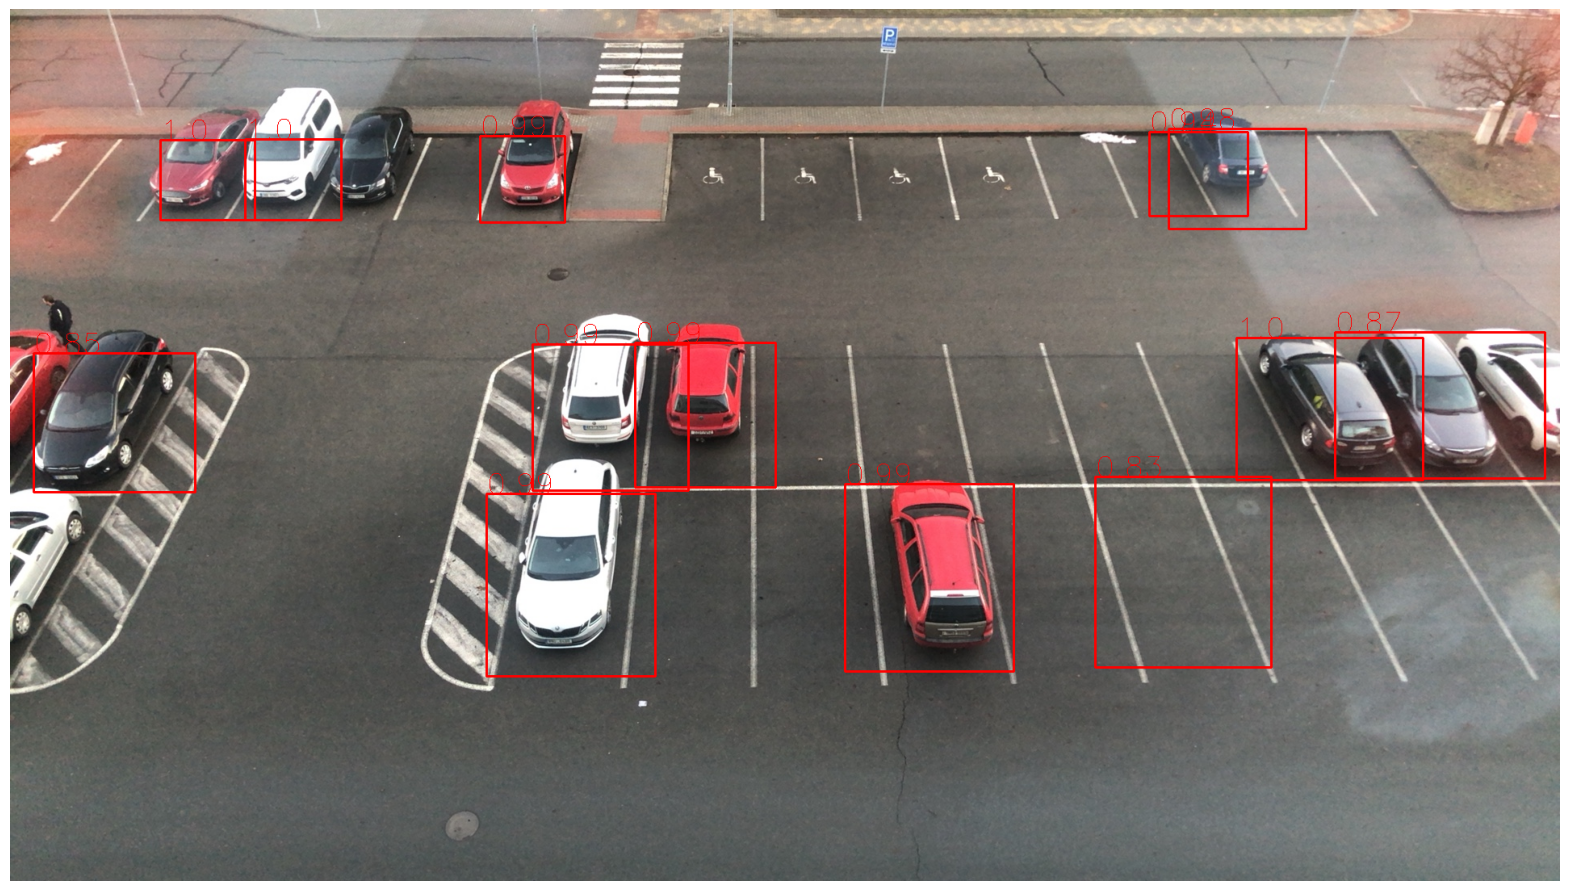

In [4]:
from torchvision import transforms
from baselines.utils.inter_utils import *
from baselines.intersection_based.inter_models import *
from baselines.utils.common_utils import seed_everything, get_device
from torch.utils.data import DataLoader
import pandas as pd
import warnings
import time

#Inference image path
image_path = f"datasets/Parking3/Picture0010.jpg"
device = get_device()

dataset = "T10LOT"
dataset_path = os.path.join("datasets/"+dataset, dataset)
model = get_model(faster_rcnn_mobilenetV3_Small_params, pretrain=False)
load_model(model, device, "Saved_Models/T10LOT_RCNN_mobilenetV3_small_retrain/state_dict_final.pth")
model.to(device)
    
#Image loading
image = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

#Image transofrmation and preprocessing
preprocess = transforms.Compose([
    # convert the frame to a CHW torch tensor for training
    transforms.ToTensor(),
    # normalize the colors to the range that mobilenet_v2/3 expect
    #transforms.Normalize(mean=mean, std=std),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)
#Running inference
model.eval()
with torch.no_grad():
    input_batch = input_batch.to(device)
    show_inference(input_batch, model, image, 0.8)